# Trajectory interpolation

Notebook: Lukas Winiwarter, 2023 and Hannah Weiser, 2026

In this demo, we present how an existing or external trajectory can be used to model platform location and attitude in a HELIOS++ simulation.

In [36]:
from pathlib import Path
from IPython.display import Code
import helios
from helios.platforms import Platform, load_traj_csv

In this example, we simulate an airborne laser scanner acquisition flying inside of a box of 100 m side length. This allows us to see the full point pattern. 

We set the platform to interpolated, and define a trajectory file in the <platformSettings > tag. This is provided by a filename and a column order. By setting syncGPSTime, we ensure that the output point cloud is in the same time system as the input trajectory.

In [37]:
box = helios.ScenePart.from_obj("../data/sceneparts/basic/box/box100.obj")
scene = helios.StaticScene(scene_parts=[box])

In [38]:
scanner = helios.scanner_from_name("riegl_lms_q560")
trajectory = load_traj_csv(
        csv="../data/trajectories/flyandrotate.trj",
        tIndex=0,
        xIndex=4,
        yIndex=5,
        zIndex=6,
        rollIndex=1,
        pitchIndex=2,
        yawIndex=3,
    )

platform = Platform.load_interpolate_platform(
    trajectory,
    "data/platforms.xml",
    "sr22",
    sync_gps_time=True,
    interpolation_method="CANONICAL")

In [39]:
trajectory

array([( 0. , 0.        , 0., 0.        ,   0., -40., 0.),
       ( 2.5, 0.        , 0., 0.        ,   0.,   0., 0.),
       ( 5. , 1.57079633, 0., 0.        ,   0.,  40., 0.),
       ( 5. , 0.        , 0., 1.57079633, -40.,   0., 0.),
       ( 7.5, 0.        , 0., 1.57079633,   0.,   0., 0.),
       (10. , 1.57079633, 0., 1.57079633,  40.,   0., 0.)],
      dtype=[('t', '<f8'), ('roll', '<f8'), ('pitch', '<f8'), ('yaw', '<f8'), ('x', '<f8'), ('y', '<f8'), ('z', '<f8')])

The contents of the trajectory file are simple: For the first 2.5 seconds, we move from `(0, -40, 0)` to `(0, 0, 0)`, with a constant attitude of `(0,0,0)` (roll, pitch, yaw). In the next 2.5 seconds, we continue to move to `(0, 40, 0)`, but rotate (roll) until we have an attitude of `(90, 0, 0)`. HELIOS++ linearly interpolates between these values.

The second half of the file shows a movement from `(-40, 0, 0)` to `(40, 0, 0)`. Note how, for the interpolated platform, the yaw angle has to be set explicitely, in this case to 90 degrees (i.e., east). Apart from these changes, the roll rotation is the same as in the first half of the file.


In [29]:
scanner_settings = helios.ScannerSettings(
        is_active=True,
        pulse_frequency=180_000 * helios.units.Hz,
        scan_frequency=100 * helios.units.Hz,
        trajectory_time_interval=0.01,
    )
trajectory_settings1 = helios.TrajectorySettings(start_time=0, end_time=5)
trajectory_settings2 = helios.TrajectorySettings(start_time=5, end_time=10)

survey = helios.Survey(scanner=scanner, platform=platform, scene=scene)
survey.add_leg(
        scanner_settings=scanner_settings, trajectory_settings=trajectory_settings1
    )
survey.add_leg(
    scanner_settings=scanner_settings, trajectory_settings=trajectory_settings2
)

In [30]:
Code(open("../data/trajectories/flyandrotate.trj").read())

#TIME_COLUMN: 0
#HEADER: "t", "roll", "pitch", "yaw", "x", "y", "z"
0, 0, 0, 0, 0, -40, 0
2.5, 0, 0, 0, 0, 0, 0
5, 90, 0, 0, 0, 40, 0
5, 0, 0, 90, -40, 0, 0
7.5, 0, 0, 90, 0, 0, 0
10, 90, 0, 90, 40, 0, 0

## Execute the survey

In [ ]:
points, traj = survey.run(verbosity=helios.LogVerbosity.VERBOSE)

## Visualizing the result

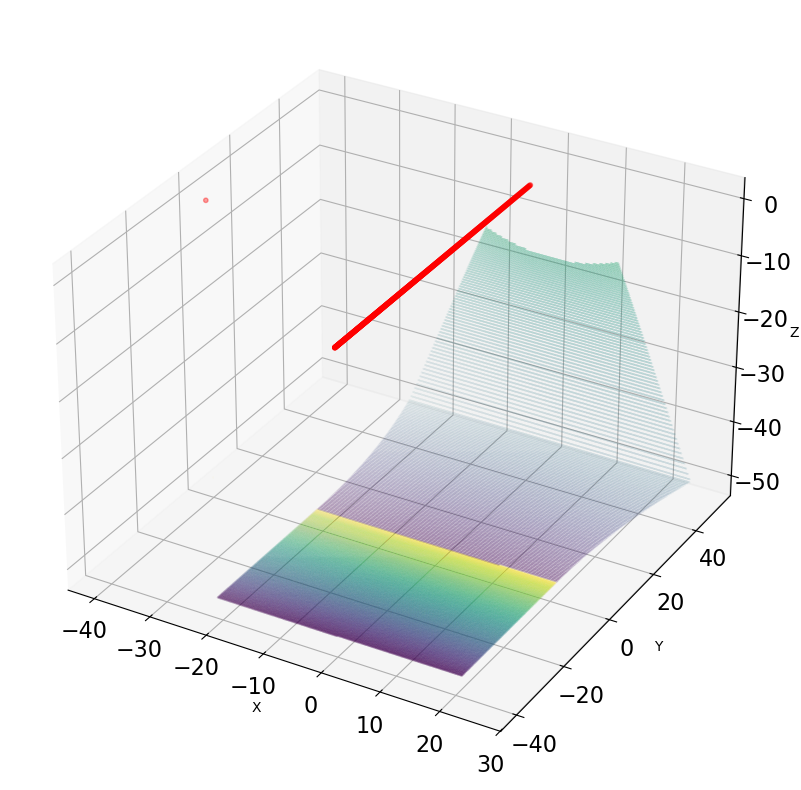

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(projection="3d")

pc1 = points[points["gps_time"] <= 2.5]
pc2 = points[(points["gps_time"] > 2.5) & (points["gps_time"] < 5)]

trj = traj[traj["gps_time"] < 5]["position"]

ax.scatter(pc1["position"][:, 0], pc1["position"][:, 1], pc1["position"][:, 2], s=0.001, c=pc1["gps_time"])
ax.scatter(pc2["position"][:, 0], pc2["position"][:, 1], pc2["position"][:, 2], s=0.001, c=pc2["gps_time"])
ax.scatter(trj[:, 0], trj[:, 1], trj[:, 2], s=10, c="red")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

ax.tick_params(labelsize=16)
plt.show()

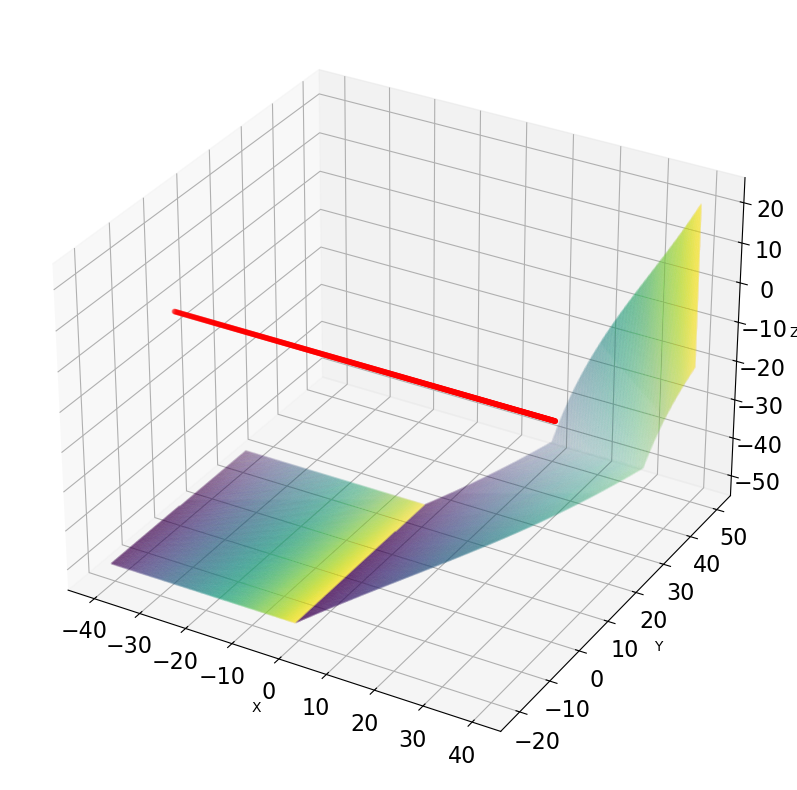

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(projection="3d")

pc1 = points[(points["gps_time"] >= 5) & (points["gps_time"] < 7.5)]
pc2 = points[points["gps_time"] > 7.5]

trj = traj[traj["gps_time"] >= 5]["position"]

ax.scatter(pc1["position"][:, 0], pc1["position"][:, 1], pc1["position"][:, 2], s=0.001, c=pc1["gps_time"])
ax.scatter(pc2["position"][:, 0], pc2["position"][:, 1], pc2["position"][:, 2], s=0.001, c=pc2["gps_time"])
ax.scatter(trj[:, 0], trj[:, 1], trj[:, 2], s=10, c="red")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

ax.tick_params(labelsize=16)
plt.show()